# ДЗ1 - имитационное обучение
Крайний срок сдачи - 20.02.2019 23:59.

***
Задача будет заключаться в том, чтобы провести эксперименты с имитационным обучением: смотреть, что такое клонирование поведеня и разобраться с алгоритмом DAgger.
Вместо человека-демонстранта демонстрации будут даваться специальной предобученной "экспертной" стартегией. Ваша задача будет заключаться в реализации алгоритма клонирования и DAgger, сравнения их произвоодительости на нескольких простых задачах управления из пакета OpenAI Gym. Ваше решение в виде Jupyter тетрадки *с комментариями* нужно загрузить по [ссылке](https://www.dropbox.com/request/uNq18mDY284JdI7o5KgJ) с шаблоном имени "Фамилия>\_ИАД<номер группы>.ipynb", например Панов_ИАД1.ipynb. Указывать ту группу, которую вы посещаете на семинарах.

__Будьте винимательны!__ В заготовках кода ниже могут быть неточности! Их правка входит в задачу выполнения ДЗ! Как минимум, вам нужно дописывать строчик кода ниже пометок __Ваш код здесь__.

## Требования:
### 1. __TensorFlow:__
Инструкции-напоминания по установке здесь - https://www.tensorflow.org/get_started/os_setup. GPU не будет требоваться для выполнения ДЗ.
### 2. __OpenAI Gym:__  
Напоминание-инструкции по OpenAI Gym - https://gym.openai.com/docs. Используйте версию 0.10.5.
### 3. __MuJoCo:__<br>
Будем использовать набор симуляционных сред MuJoCo.  Загружайте версию 1.50 с http://mujoco.org/,  и версию  1.50.1.56  с https://github.com/openai/mujoco-py/. Для активации доступа можно испоьзовать ваше университетский аккаунт -  https://www.roboti.us/license.html.
***

Импортируем все необходимое:

In [8]:
# ЧТОБЫ ПОСМОТРЕТЬ ВИЗУАЛИЗАЦИИ МОДЕЛЕЙ, НАДО ЗАКОММЕНТИТЬ env.close() И РАСКОММЕНТЕТЬ env.render()
# Но если не раскомменчивать, кернел не умирает

import os
import pickle
import tensorflow as tf
print("TensorFlow version :",tf.__version__)

import numpy as np
import tf_util
import gym
print("Gym version :",gym.__version__)

import glfw
import load_policy
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

%matplotlib inline
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

TensorFlow version : 1.11.0
Gym version : 0.11.0


***
## Сборием статистику

 Генерируем статистику (roll-outs) по заданной экспертной стратегии в 3 шага:
 1. Загружаем стратегию из файла и инициализируем окружение.
 2. Начинаем сессию tensorflow.
 3. В рамках сессии собираем данные: до конца эпизода в цикле выбираем экспертное действие, применяем его и сохраняем результаты.

In [9]:
#choose environment (Uncomment choosed one)
env_name="Humanoid-v2"
#env_name="Ant-v2"
#env_name="HalfCheetah-v2"
#env_name="Hopper-v2"
#env_name="Reacher-v2"
#env_name="Walker2d-v2"

expert_policy_file = "experts/" + env_name + ".pkl"

print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

env = gym.make(env_name)
 
def generate_rollouts(num_rollouts,max_steps,render=False):
    with tf.Session():
        tf_util.initialize()

        returns = []
        observations = []
        actions = []

        for i in range(num_rollouts):
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                # choose an action depending on the observation
                action = policy_fn(obs[None,:])
                # append sample to arrays
                observations.append(obs)
                actions.append(action)
                # apply the action on the environment
                obs, r, done, _ = env.step(action)
                # calculate the total reward
                totalr += r
                steps += 1
                # render the environment
                if render==True:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            # append the total reward
            returns.append(totalr)
        
        # print the reward information
        #print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),'actions': np.array(actions)}
            
        return expert_data

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built


Тестируем реализованную функцию: num_rollouts=4,max_steps=100,render=True

Notes:
- If the camera doesn't track the agent, prss __Tab__ to change the viewpoint
- In some cases the jupyter notebok kernel will crash if you close the rendering window, __don't close the windows until finishing the execution of the whole notebook.__

In [3]:
generate_rollouts(num_rollouts=4,max_steps=100,render=True);

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
Creating window glfw
mean return 648.4772709159199
std of return 12.217618417329849


***
## 1. Клонирование поведения

Клонирование поведения (Behavioural cloning, BC) - метод, с помощью когорого компьютерная программа обучается воспроизводить действия эксперта (человека). Действия эксперта записываются, а затем эта статистика используется как входные данные для алгоритма обучения. Этот алгоритм в результате формирует последовательность действий, по которым воспроизводится поведение эксперта.

Будем использовать стандартное обучение с учителем и использовать нейронную сеть для этого.

Кроме конструктора, вам нужно дореализовать метод __train__ класса __BC_Model__:

In [10]:
class BC_Model(object):
    def __init__(self, input_data, output_data, batch_size = 64, if_reset=False):
        if if_reset is True:
            tf.reset_default_graph() 
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        ### Ваш код здесь - нужно добавить функцию потерь l2_loss ###]
        self.loss = tf.nn.l2_loss(self.output_placeholder_model)
        
# Пробую многослойный перцептрон с двумя скрытыми слоями
# Игра с гиперпараметрами практически не влияет на результат

    def build_model(self, input_placeholder):
        tf.set_random_seed(42)
        w1 = tf.Variable(tf.random_normal([376, 300]))
        w2 = tf.Variable(tf.random_normal([300, 300]))
        w3 = tf.Variable(tf.random_normal([300, 17]))
        inner_layer_1 = tf.add(tf.matmul(input_placeholder, w1), tf.Variable(tf.random_normal([300])))
        relu = tf.nn.relu(inner_layer_1)
        drop = tf.nn.dropout(relu, 0.25)
        inner_layer_2 = tf.add(tf.matmul(inner_layer_1, w2), tf.Variable(tf.random_normal([300])))
        relu_2 = tf.nn.relu(inner_layer_2)
        drop_2 = tf.nn.dropout(relu_2, 0.25)
        out_layer = tf.matmul(inner_layer_2, w3) + tf.Variable(tf.random_normal([17]))
        out = tf.layers.dense(out_layer, units=17, activation=tf.nn.relu)
        return out

    def train(self, epochs=20, train_data=None, test_data=None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

### Обучем модель на экспертных данных

In [11]:
# generate expert data
data = generate_rollouts(num_rollouts=20,max_steps=100,render=False);
x = data['observations']
y = data['actions']
print('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x, y = shuffle(x,y)

# create an object from BC_Model class, and train it
tf.set_random_seed(21)
cloner = BC_Model(x,y, if_reset=True)
cloner.train(train_data=x, test_data=y)

mean return 639.6567632493387
std of return 9.818917793616457
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)


### Испытываем модель

In [12]:
num_eval_rollouts=20
# loop over runouts
human_returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr = 0.
    done = False
    obs = env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        #action = policy_fn(obs[None,:])
        action = cloner.sample(obs)
        # implement the action
        obs,r,done,_ = env.step(action)
        #env.render()
        env.close()
        totalr +=r
    human_returns.append(totalr)

print('mean return', np.mean(human_returns))
print('std of return', np.std(human_returns))

mean return 113.39168721144873
std of return 2.3873321249850554


__Задание 1.1.__ Вам необходимо обучить модель на любых трех окружениях MoJoCo. Построить графики отдачи (totalr) в зависимости от количества набранной статистики (num_rollouts) для обучения.

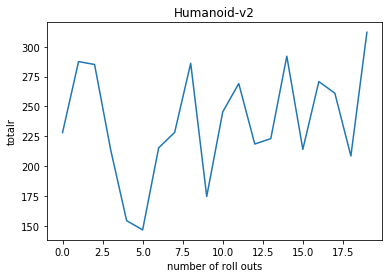

In [8]:
# ГРАФИК ДЛЯ ЧЕЛОВЕЧКА
plt.title("Humanoid-v2")
plt.plot([x for x in range(num_eval_rollouts)], human_returns)
plt.xlabel("number of roll outs")
plt.ylabel("totalr")

plt.show()

# Вывод - достаточно существенно влияет, на ~20 отдача подошла достаточно близко к экспертным данным

In [13]:
env_name="Ant-v2"

class BC_Model_ant(object):
    def __init__(self, input_data, output_data, batch_size = 64, if_reset=False):
        if if_reset is True:
            tf.reset_default_graph()
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        self.loss = tf.nn.l2_loss(self.output_placeholder_model)
        

    def build_model(self, input_placeholder):
        tf.set_random_seed(42)
        w1 = tf.Variable(tf.random_normal([111, 15]))
        w2 = tf.Variable(tf.random_normal([15, 15]))
        w3 = tf.Variable(tf.random_normal([15, 8]))
        inner_layer_1 = tf.add(tf.matmul(input_placeholder, w1), tf.Variable(tf.random_normal([15])))
        #relu = tf.nn.relu(inner_layer_1)
        #drop = tf.nn.dropout(relu, 0.25)
        inner_layer_2 = tf.add(tf.matmul(inner_layer_1, w2), tf.Variable(tf.random_normal([15])))
        #relu_2 = tf.nn.relu(inner_layer_2)
        #drop_2 = tf.nn.dropout(relu_2, 0.25)
        out_layer = tf.matmul(inner_layer_2, w3) + tf.Variable(tf.random_normal([8]))
        #out = tf.layers.dense(out_layer, units=6, activation=tf.nn.relu)
        return out_layer

    def train(self, epochs = 20, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]
    
# generate expert data
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)

# make the environment
env = gym.make(env_name)

data = generate_rollouts(num_rollouts=20,max_steps=100,render=False);
x = data['observations']
y = data['actions']

x, y = shuffle(x,y)

cloner = BC_Model_ant(x,y, if_reset=True)
cloner.train(epochs=20)

num_eval_rollouts=20
# loop over runouts
ant_returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr = 0
    done = False
    obs = env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action = cloner.sample(obs)
        # implement the action
        obs,r,done,_ = env.step(action)
        #env.render()
        env.close()
        totalr +=r
    ant_returns.append(totalr)
print('mean return', np.mean(ant_returns))
print('std of return', np.std(ant_returns))

obs (1, 111) (1, 111)
mean return 415.33333624795785
std of return 30.449209494071038
mean return -847587.6538717194
std of return 439937.88304448425


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


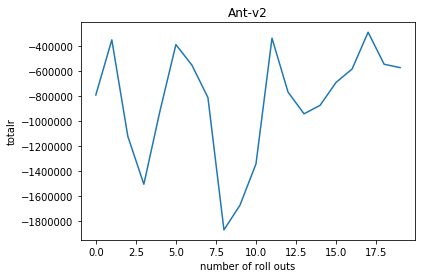

In [14]:
# ГРАФИК ДЛЯ ПАВУЧКА
# Почему-то с этой же моделью все намного хуже...

plt.title("Ant-v2")
plt.plot([x for x in range(num_eval_rollouts)], ant_returns)
plt.xlabel("number of roll outs")
plt.ylabel("totalr")

plt.show()

In [3]:
env_name="HalfCheetah-v2"

class BC_Model_cheet(object):
    def __init__(self, input_data, output_data, batch_size = 64, if_reset=False):
        if if_reset is True:
            tf.reset_default_graph()
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        self.loss = tf.nn.l2_loss(self.output_placeholder_model)
        

    def build_model(self, input_placeholder):
        tf.set_random_seed(42)
        w1 = tf.Variable(tf.random_normal([17, 15]))
        w2 = tf.Variable(tf.random_normal([15, 15]))
        w3 = tf.Variable(tf.random_normal([15, 6]))
        inner_layer_1 = tf.add(tf.matmul(input_placeholder, w1), tf.Variable(tf.random_normal([15])))
        #relu = tf.nn.relu(inner_layer_1)
        #drop = tf.nn.dropout(relu, 0.25)
        inner_layer_2 = tf.add(tf.matmul(inner_layer_1, w2), tf.Variable(tf.random_normal([15])))
        #relu_2 = tf.nn.relu(inner_layer_2)
        #drop_2 = tf.nn.dropout(relu_2, 0.25)
        out_layer = tf.matmul(inner_layer_2, w3) + tf.Variable(tf.random_normal([6]))
        #out = tf.layers.dense(out_layer, units=6, activation=tf.nn.relu)
        return out_layer

    def train(self, epochs = 20, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]
    
# generate expert data
expert_policy_file = "experts/" + env_name + ".pkl"
policy_fn = load_policy.load_policy(expert_policy_file)
env = gym.make(env_name)

data = generate_rollouts(num_rollouts=20,max_steps=100,render=False);
x = data['observations']
y = data['actions']
print('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x, y = shuffle(x,y)

# create an object from BC_Model class, and train it
cloner = BC_Model_cheet(x,y, if_reset=True)
cloner.train()

num_eval_rollouts=20
# loop over runouts
cheet_returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr = 0
    done = False
    obs = env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action = cloner.sample(obs)
        # implement the action
        obs,r,done,_ = env.step(action)
        #env.render()
        env.close()
        totalr +=r
    cheet_returns.append(totalr)
print('mean return', np.mean(cheet_returns))
print('std of return', np.std(cheet_returns))

obs (1, 17) (1, 17)
Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
mean return 289.5423153160002
std of return 14.955773740994983
dimension of obs : (2000, 17)
dimension of actions : (2000, 1, 6)
mean return -52013712.2218867
std of return 875049.7903697414


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


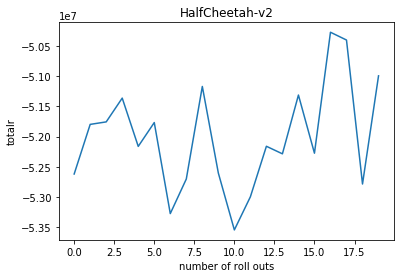

In [4]:
# ГРАФИК ДЛЯ ЛИОПАРДА
# тут тоже не очень, но он хотя бы двигается прямо

plt.title("HalfCheetah-v2")
plt.plot([x for x in range(20)], cheet_returns)
plt.xlabel("number of roll outs")
plt.ylabel("totalr")

plt.show()

__Задание 1.2.__ Выберите один из гиперапараметров вашей модели, которые влияют на качество обучения (количество эпох, количество слоев и т.п.). Для одного из окружений постройте график влияния значения этого параметра на качество обучения (totalr).

In [86]:
epochs = [i for i in range(0, 110, 10)]
res = []

data = generate_rollouts(num_rollouts=20,max_steps=100,render=False)
x = data['observations']
y = data['actions']
x, y = shuffle(x,y)

for e in epochs:
    print("AMOUNT OF EPOCHS:", e)
    cloner = BC_Model(x,y)
    cloner.train(epochs=e)
    num_eval_rollouts=50
    returns=[]
    for i in range(num_eval_rollouts):
        totalr = 0
        done = False
        obs = env.reset()
        while not done:
            action = cloner.sample(obs)
            obs,r,done,_ = env.step(action)
            #env.render()
            env.close()
            totalr +=r
        returns.append(totalr)
    res.append(np.mean(returns))

mean return 642.5425247491171
std of return 10.456716290494107
AMOUNT OF EPOCHS: 0
AMOUNT OF EPOCHS: 10
AMOUNT OF EPOCHS: 20
AMOUNT OF EPOCHS: 30
AMOUNT OF EPOCHS: 40
AMOUNT OF EPOCHS: 50
AMOUNT OF EPOCHS: 60
AMOUNT OF EPOCHS: 70
AMOUNT OF EPOCHS: 80
AMOUNT OF EPOCHS: 90
AMOUNT OF EPOCHS: 100


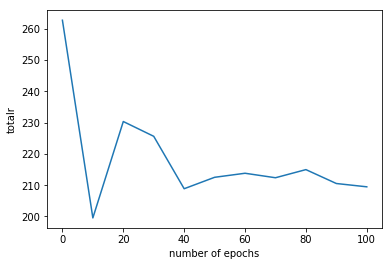

In [87]:
plt.plot(epochs, res)
plt.xlabel("number of epochs")
plt.ylabel("totalr")

plt.show()

# вывод - эпох должно быть в меру, после 20 эпох никакого роста нет

***
## 2. DAgger Algorithm

Цель алгоритма DAgger (data Aggregation) - собрать статистику обучаемой модели, вместо экспертных данных. 
- Вначале мы тренируем BC_Model на собранных экспертных данных.
- Запускаем модель на окружениие, собираем наблюдения.
- Затем мы просим эксперта (человека) отметить, какие действия нужно совершать в полученных наблюдениях (по сути используем __policy_fn__).
- Создаем новую коллекцию помеченных и экспертных данных.
- Потворяем.

In [9]:
env_name="Humanoid-v2"

expert_policy_file = "experts/" + env_name + ".pkl"

print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

data = generate_rollouts(num_rollouts=20,max_steps=100,render=False)
x = data['observations']
y = data['actions']
print('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x, y = shuffle(x,y)

cloner = BC_Model(x, y)
cloner.train()

with tf.Session():
    DAgger_iter = 30
    render = False
    # DAgger loop
    for i in range(DAgger_iter):
        # reset in each iteration
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # collect data from model and expert
        while not done:
            # get an action from the model
            ### Ваш код здесь - испольузуем оубченную модель ###
            # action = ...
            action = cloner.sample(obs)
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            # get the expert action for the same input
            ### Ваш код здесь - испольузуем olicy_fn!! ###
            # corrected_action = 
            corrected_action = policy_fn(obs[None,:])
            # append the observation and expert action to the data set
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # re-order the data
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        # train the model on the collected data
        ### Ваш код здесь - дообучаем модель ###
        # cloner.train...
        cloner.train(train_data=x, test_data=y)

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
mean return 638.7835255546721
std of return 10.944125517475088
dimension of obs : (2000, 376)
dimension of actions : (2000, 1, 17)


### Проверяем работу

In [10]:
num_eval_rollouts=20
# loop over runouts
hum_dagger_returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        #env.render()
        env.close()
        totalr+=r
    hum_dagger_returns.append(totalr)
print('mean return', np.mean(hum_dagger_returns))
print('std of return', np.std(hum_dagger_returns))

mean return 229.7761632816972
std of return 66.08892824998522


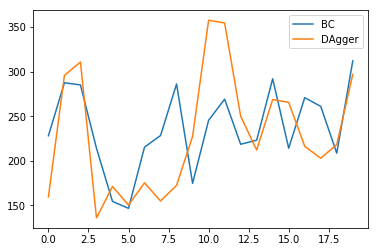

In [16]:
plt.plot([x for x in range(20)], human_returns, label='BC')
plt.plot([x for x in range(20)], hum_dagger_returns, label='DAgger')
plt.legend(loc='best')
plt.show()

# Вывод - Даггер в среднем повышает величину возраграждения в сравнении с ВС у этого агента

__Задание 2.1.__ Проверьте работу DAagger на всех задачах MoJoCo - укажите для какой задачи он работает лучше, чем простое клонирование. Покажите это на графиках.

In [15]:
env_name="Ant-v2"

expert_policy_file = "experts/" + env_name + ".pkl"

print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

env = gym.make(env_name)

data = generate_rollouts(num_rollouts=20,max_steps=100,render=False)
x = data['observations']
y = data['actions']
print('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x, y = shuffle(x,y)

cloner = BC_Model_ant(x, y)
cloner.train()

with tf.Session():
    DAgger_iter = 30
    render = False
    # DAgger loop
    for i in range(DAgger_iter):
        # reset in each iteration
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # collect data from model and expert
        while not done:
            # get an action from the model
            ### Ваш код здесь - испольузуем оубченную модель ###
            # action = ...
            action = cloner.sample(obs)
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            # append the observation and expert action to the data set
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # re-order the data
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=x, test_data=y)

loading and building expert policy
obs (1, 111) (1, 111)
loaded and built
mean return 433.4726998292009
std of return 28.406819945126696
dimension of obs : (2000, 111)
dimension of actions : (2000, 1, 8)


In [16]:
num_eval_rollouts=20
# loop over runouts
ant_dagger_returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        #env.render()
        env.close()
        totalr+=r
    ant_dagger_returns.append(totalr)
print('mean return', np.mean(ant_dagger_returns))
print('std of return', np.std(ant_dagger_returns))

Creating window glfw
mean return -2284589.963471208
std of return 3953287.657924425


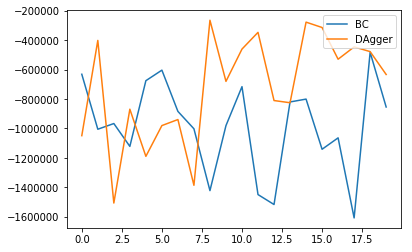

In [22]:
plt.plot([x for x in range(20)], ant_returns, label='BC')
plt.plot([x for x in range(20)], ant_dagger_returns, label='DAgger')
plt.legend(loc='best')
plt.show()

# Вывод - Даггер в среднем повышает величину возраглаждения в сравнении с ВС у этого агента,
# но вообще что то фигня, что это

In [32]:
env_name="HalfCheetah-v2"

expert_policy_file = "experts/" + env_name + ".pkl"

print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

env = gym.make(env_name)

data = generate_rollouts(num_rollouts=20,max_steps=100,render=False)
x = data['observations']
y = data['actions']
print('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x, y = shuffle(x,y)

cloner = BC_Model_cheet(x, y)
cloner.train()

with tf.Session():
    DAgger_iter = 30
    render = False
    # DAgger loop
    for i in range(DAgger_iter):
        # reset in each iteration
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # collect data from model and expert
        while not done:
            action = cloner.sample(obs)
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            # append the observation and expert action to the data set
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # re-order the data
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=x, test_data=y)

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
mean return 283.57138329632653
std of return 22.869741566147564
dimension of obs : (2000, 17)
dimension of actions : (2000, 1, 6)


In [33]:
num_eval_rollouts=20
# loop over runouts
cheet_dagger_returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        #env.render()
        env.close()
        totalr+=r
    cheet_dagger_returns.append(totalr)
print('mean return', np.mean(cheet_dagger_returns))
print('std of return', np.std(cheet_dagger_returns))

mean return -430.2392297915894
std of return 215.5831602600348


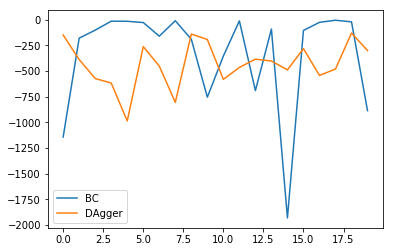

In [34]:
plt.plot([x for x in range(20)], cheet_returns, label='BC')
plt.plot([x for x in range(20)], cheet_dagger_returns, label='DAgger')
plt.legend(loc='best')
plt.show()

# Тут BC кажется лучше, но опять же

In [4]:
env_name="Hopper-v2"

class BC_Model_hopper(object):
    def __init__(self, input_data, output_data, batch_size = 64, if_reset=False):
        if if_reset is True:
            tf.reset_default_graph()
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        self.loss = tf.nn.l2_loss(self.output_placeholder_model)
        

    def build_model(self, input_placeholder):
        tf.set_random_seed(42)
        w1 = tf.Variable(tf.random_normal([11, 15]))
        w2 = tf.Variable(tf.random_normal([15, 15]))
        w3 = tf.Variable(tf.random_normal([15, 64]))
        inner_layer_1 = tf.add(tf.matmul(input_placeholder, w1), tf.Variable(tf.random_normal([15])))
        relu = tf.nn.relu(inner_layer_1)
        drop = tf.nn.dropout(relu, 0.25)
        inner_layer_2 = tf.add(tf.matmul(drop, w2), tf.Variable(tf.random_normal([15])))
        relu_2 = tf.nn.relu(inner_layer_2)
        drop_2 = tf.nn.dropout(relu_2, 0.25)
        out_layer = tf.matmul(drop_2, w3) + tf.Variable(tf.random_normal([64]))
        out = tf.layers.dense(out_layer, units=3, activation=tf.nn.relu)
        return out

    def train(self, epochs = 20, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

In [5]:
env_name="Hopper-v2"

expert_policy_file = "experts/" + env_name + ".pkl"

print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

env = gym.make(env_name)

data = generate_rollouts(num_rollouts=20,max_steps=100,render=False)
x = data['observations']
y = data['actions']
print('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x, y = shuffle(x,y)

cloner = BC_Model_hopper(x, y)
cloner.train()

with tf.Session():
    DAgger_iter = 30
    render = False
    # DAgger loop
    for i in range(DAgger_iter):
        # reset in each iteration
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # collect data from model and expert
        while not done:
            action = cloner.sample(obs)
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            # append the observation and expert action to the data set
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # re-order the data
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=x, test_data=y)

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
mean return 228.08311340495771
std of return 0.5779743746774755
dimension of obs : (2000, 11)
dimension of actions : (2000, 1, 3)


In [6]:
num_eval_rollouts=20
# loop over runouts
hop_returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        #env.render()
        env.close()
        totalr+=r
    hop_returns.append(totalr)
print('mean return', np.mean(hop_returns))
print('std of return', np.std(hop_returns))

mean return 123.80991942265707
std of return 27.929587967364583


In [7]:
env_name="Reacher-v2"

class BC_Model_reacher(object):
    def __init__(self, input_data, output_data, batch_size = 64, if_reset=False):
        if if_reset is True:
            tf.reset_default_graph()
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        self.loss = tf.nn.l2_loss(self.output_placeholder_model)
        

    def build_model(self, input_placeholder):
        tf.set_random_seed(42)
        w1 = tf.Variable(tf.random_normal([11, 15]))
        w2 = tf.Variable(tf.random_normal([15, 15]))
        w3 = tf.Variable(tf.random_normal([15, 64]))
        inner_layer_1 = tf.add(tf.matmul(input_placeholder, w1), tf.Variable(tf.random_normal([15])))
        relu = tf.nn.relu(inner_layer_1)
        drop = tf.nn.dropout(relu, 0.25)
        inner_layer_2 = tf.add(tf.matmul(drop, w2), tf.Variable(tf.random_normal([15])))
        relu_2 = tf.nn.relu(inner_layer_2)
        drop_2 = tf.nn.dropout(relu_2, 0.25)
        out_layer = tf.matmul(drop_2, w3) + tf.Variable(tf.random_normal([64]))
        out = tf.layers.dense(out_layer, units=2, activation=tf.nn.relu)
        return out

    def train(self, epochs = 20, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

In [8]:
env_name="Reacher-v2"

expert_policy_file = "experts/" + env_name + ".pkl"

print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

env = gym.make(env_name)

data = generate_rollouts(num_rollouts=20,max_steps=100,render=False)
x = data['observations']
y = data['actions']
print('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x, y = shuffle(x,y)

cloner = BC_Model_reacher(x, y)
cloner.train()

with tf.Session():
    DAgger_iter = 30
    render = False
    # DAgger loop
    for i in range(DAgger_iter):
        # reset in each iteration
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # collect data from model and expert
        while not done:
            action = cloner.sample(obs)
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            # append the observation and expert action to the data set
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # re-order the data
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=x, test_data=y)

loading and building expert policy
obs (1, 11) (1, 11)
loaded and built
mean return -3.6993266792040544
std of return 1.2272940599794264
dimension of obs : (1000, 11)
dimension of actions : (1000, 1, 2)


In [9]:
num_eval_rollouts=20
# loop over runouts
reacher_returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        #env.render()
        env.close()
        totalr+=r
    reacher_returns.append(totalr)
print('mean return', np.mean(reacher_returns))
print('std of return', np.std(reacher_returns))

mean return -608.0012774360216
std of return 612.1514573415986


In [10]:
env_name="Walker2d-v2"

class BC_Model_reacher(object):
    def __init__(self, input_data, output_data, batch_size = 64, if_reset=False):
        if if_reset is True:
            tf.reset_default_graph()
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        self.loss = tf.nn.l2_loss(self.output_placeholder_model)
        

    def build_model(self, input_placeholder):
        tf.set_random_seed(42)
        w1 = tf.Variable(tf.random_normal([17, 15]))
        w2 = tf.Variable(tf.random_normal([15, 15]))
        w3 = tf.Variable(tf.random_normal([15, 64]))
        inner_layer_1 = tf.add(tf.matmul(input_placeholder, w1), tf.Variable(tf.random_normal([15])))
        relu = tf.nn.relu(inner_layer_1)
        drop = tf.nn.dropout(relu, 0.25)
        inner_layer_2 = tf.add(tf.matmul(drop, w2), tf.Variable(tf.random_normal([15])))
        relu_2 = tf.nn.relu(inner_layer_2)
        drop_2 = tf.nn.dropout(relu_2, 0.25)
        out_layer = tf.matmul(drop_2, w3) + tf.Variable(tf.random_normal([64]))
        out = tf.layers.dense(out_layer, units=6, activation=tf.nn.relu)
        return out

    def train(self, epochs = 20, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

In [12]:
env_name="Walker2d-v2"

expert_policy_file = "experts/" + env_name + ".pkl"

print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

env = gym.make(env_name)

data = generate_rollouts(num_rollouts=20,max_steps=100,render=False)
x = data['observations']
y = data['actions']
print('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x, y = shuffle(x,y)

cloner = BC_Model_reacher(x, y)
cloner.train()

with tf.Session():
    DAgger_iter = 30
    render = False
    # DAgger loop
    for i in range(DAgger_iter):
        print(i)
        # reset in each iteration
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # collect data from model and expert
        while not done:
            # get an action from the model
            ### Ваш код здесь - испольузуем оубченную модель ###
            # action = ...
            action = cloner.sample(obs)
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            corrected_action = policy_fn(obs[None,:])
            # append the observation and expert action to the data set
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # re-order the data
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        cloner.train(train_data=x, test_data=y)

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built
mean return 221.4533857943277
std of return 1.171880963605463
dimension of obs : (2000, 17)
dimension of actions : (2000, 1, 6)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [14]:
num_eval_rollouts=20
# loop over runouts
walker_returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
        #env.render()
        env.close()
        totalr+=r
    walker_returns.append(totalr)
print('mean return', np.mean(walker_returns))
print('std of return', np.std(walker_returns))

mean return 263.6282680292881
std of return 100.0097035620857


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


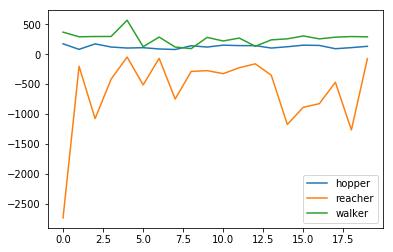

In [15]:
# У этих агентов +- одинаковые реводры на экспертных данных, можно сравнить на одном графике

plt.plot([x for x in range(20)], hop_returns, label='hopper')
plt.plot([x for x in range(20)], reacher_returns, label='reacher')
plt.plot([x for x in range(20)], walker_returns, label='walker')
plt.legend(loc='best')
plt.show()

# Вывод - Даггер в среднем повышает величину возраглаждения в сравнении с ВС, но вообще что то фигня, что это

In [ ]:
# Вывод - волкер решается +- лучше всех среди задач